In [1]:
import ipywidgets as widgets

text_input1 = widgets.Text()
text_input1.style.description_width = 'initial'  # Set description width to initial, allowing longer descriptions
text_input1.description = 'Enter the model for feature extraction: '

text_input2 = widgets.Text()
text_input2.style.description_width = 'initial'  # Set description width to initial, allowing longer descriptions
text_input2.description = 'Enter the Sequential model : '

# Define variables to store the input values
feature_model = None
sequence_model = None

# Display the widgets
display(text_input1)
display(text_input2)

# Define a function to handle the input
def handle_submit(sender):
    global feature_model, sequence_model
    feature_model = text_input1.value
    sequence_model = text_input2.value

# Set the function to handle input submission
text_input1.on_submit(handle_submit)
text_input2.on_submit(handle_submit)


Text(value='', description='Enter the model for feature extraction: ', style=TextStyle(description_width='init…

Text(value='', description='Enter the Sequential model : ', style=TextStyle(description_width='initial'))

/var/folders/9d/b0mdn8zd7msdn25jg6z_ln3c0000gn/T/ipykernel_22400/266145124.py:26: DeprecationWarning: on_submit is deprecated. Instead, set the .continuous_update attribute to False and observe the value changing with: mywidget.observe(callback, 'value').
  text_input1.on_submit(handle_submit)
/var/folders/9d/b0mdn8zd7msdn25jg6z_ln3c0000gn/T/ipykernel_22400/266145124.py:27: DeprecationWarning: on_submit is deprecated. Instead, set the .continuous_update attribute to False and observe the value changing with: mywidget.observe(callback, 'value').
  text_input2.on_submit(handle_submit)


In [2]:
from pickle import load as pickle_load
import string
import numpy as np
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import corpus_bleu
import json
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical


def captions_to_list(caption_dictionary):
    # Return: a list of all captions from the caption_dict
    captions = []
    for caption_list in caption_dictionary.values():
        for c in caption_list:
            captions.append(c)
    return captions


def create_tokenizer(caption_dictionary, num_vocab=None):
    """
    Input: caption dictionary, num_vocab
    Output: Tokenizer fitted on the captions in the dictionary, with maximum number of vocab = num_vocab
    """
    tokenizer = Tokenizer(num_words=num_vocab, filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')
    captions = captions_to_list(caption_dictionary)
    tokenizer.fit_on_texts(captions)
    return tokenizer


def load_dataset(filename):
    """
    Input: filename of dataset
    Output: A list of identifiers in the dataset
    """
    dataset = []
    with open(filename, "r") as file:
        text = file.read()

    for line in text.split('\n'):
        if len(line) < 1:
            continue
        dataset.append(line.split('.')[0])

    return dataset

def load_image_features(dataset, file_name):
    """
    Input: dataset (list of identifier)
    Output: The VGG-16 features according to the identifiers
    """
    with open(file_name, "rb") as file:
        features = pickle_load(file)
    features = {photo_id: features[photo_id] for photo_id in dataset}

    return features

def load_captions(dataset, wrapping=0):
    """
    Input: dataset (list of identifier), wrapping (by startseq / endseq)
    Output: The caption dictionary according to the identifiers, with / without wrapping of (startseq, endseq)
    """
    with open("captions.pkl", "rb") as file:
        caption_dictionary = pickle_load(file)
    caption_dictionary = {photo_id: caption_dictionary[photo_id] for photo_id in dataset}

    if wrapping:
        for photo_id, caption_list in caption_dictionary.items():
            for i in range(len(caption_list)):
                tmp = caption_list[i].split()
                caption_list[i] = '<startseq> ' + ' '.join(tmp) + ' <endseq>'

    return caption_dictionary



def define_model_lstm(max_length, vocab_size, dp_rate=0.1, embed_size=100, embedding_matrix=None):
    img_inputs = keras.layers.Input(shape=(4096,))
    img_dp1 = keras.layers.Dropout(rate=dp_rate)(img_inputs)
    img_dense = keras.layers.Dense(64)(img_dp1)
    img_bn1 = keras.layers.BatchNormalization()(img_dense)
    img_outputs = keras.layers.Activation(activation='relu')(img_bn1)
    #RepeatVector for matching timestep
    img_rep = keras.layers.RepeatVector(n=max_length)(img_outputs)
    
    text_inputs = keras.layers.Input(shape=(max_length,))
    if embedding_matrix is None:
        text_embed = keras.layers.Embedding(input_dim=vocab_size, 
                                            output_dim=embed_size, 
                                            mask_zero=True,
                                            name='text_embedding')(text_inputs)
        
    else:
        text_embed = keras.layers.Embedding(input_dim=vocab_size, 
                                            output_dim=embed_size, 
                                            mask_zero=True,
                                            embeddings_initializer=keras.initializers.Constant(embedding_matrix),
                                            trainable=False,
                                            name='text_embedding')(text_inputs)
            
    text_dp1 = keras.layers.Dropout(rate=dp_rate)(text_embed)
    text_lstm = keras.layers.LSTM(64, return_sequences=True)(text_dp1)
    
    decoder_inputs = keras.layers.Concatenate()([img_rep, text_lstm])
    decoder_dp1 = keras.layers.Dropout(rate=dp_rate, noise_shape=(None, 1, 128))(decoder_inputs)
    decoder_dense1 = keras.layers.Dense(256)(decoder_dp1)
    decoder_dp2 = keras.layers.Dropout(rate=dp_rate, noise_shape=(None, 1, 256))(decoder_dense1)
    decoder_relu1 = keras.layers.Activation(activation='relu')(decoder_dp2)
    decoder_outputs = keras.layers.Dense(vocab_size, activation='softmax')(decoder_relu1)
    
    model = keras.models.Model(inputs = [img_inputs, text_inputs], outputs=decoder_outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    print(model.summary())
    
    return(model)

def define_model_rnn(max_length, vocab_size, dp_rate=0.1, embed_size=100, embedding_matrix = None):
    img_inputs = keras.layers.Input(shape=(4096,))
    img_dp1 = keras.layers.Dropout(rate=dp_rate)(img_inputs)
    img_dense = keras.layers.Dense(64)(img_dp1)
    img_bn1 = keras.layers.BatchNormalization()(img_dense)
    img_outputs = keras.layers.Activation(activation='relu')(img_bn1)
    img_rep = keras.layers.RepeatVector(n=max_length)(img_outputs)
    
    text_inputs = keras.layers.Input(shape=(max_length,))
    if embedding_matrix is None:
        print('embedding_matrix is not available')
        text_embed = keras.layers.Embedding(input_dim=vocab_size, 
                                            output_dim=embed_size, 
                                            mask_zero=True,
                                            name='text_embedding')(text_inputs)
        
    else:
        print('embedding_matrix is available')
        text_embed = keras.layers.Embedding(input_dim=vocab_size, 
                                            output_dim=embed_size, 
                                            mask_zero=True,
                                            embeddings_initializer=keras.initializers.Constant(embedding_matrix),
                                            trainable=False,
                                            name='text_embedding')(text_inputs)
            
    text_dp1 = keras.layers.Dropout(rate=dp_rate)(text_embed)
    text_rnn = keras.layers.SimpleRNN(64, return_sequences=True)(text_dp1)
    
    decoder_inputs = keras.layers.Concatenate()([img_rep, text_rnn])
    decoder_dp1 = keras.layers.Dropout(rate=dp_rate, noise_shape=(None, 1, 128))(decoder_inputs)
    decoder_dense1 = keras.layers.Dense(256)(decoder_dp1)
    decoder_dp2 = keras.layers.Dropout(rate=dp_rate, noise_shape=(None, 1, 256))(decoder_dense1)
    decoder_relu1 = keras.layers.Activation(activation='relu')(decoder_dp2)
    decoder_outputs = keras.layers.Dense(vocab_size, activation='softmax')(decoder_relu1)
    
    model = keras.models.Model(inputs=[img_inputs, text_inputs], outputs=decoder_outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    print(model.summary())
    
    return model

def generate_dataset(caption_dictionary, features, tokenizer, max_length, vocab_size, num_photos=32):
    """
    A generator of dataset for model training / validation.
    Input: train / val (caption_dict & features)
    Yield: a batch of [[X_img, X_text], Y] as the model input for model.fit_generator() / model.evaluate_generator()
    """

    photo_ids = list(caption_dictionary.keys())
    while True:
        s = np.random.choice(np.arange(len(photo_ids)), size=len(photo_ids), replace=False)

        count = 0
        X_img = []
        X_text = []
        Y = []
        while True:
            s1 = s[count]
            photo_id = photo_ids[s1]
            caption_list = caption_dictionary[photo_id]

            s2 = np.random.choice(np.arange(len(caption_list)), size=1, replace=True)[0]
            caption = caption_list[s2]
            encoded = tokenizer.texts_to_sequences([caption])[0]

            tmp_text, tmp_Y = encoded[:-1], encoded[1:]
            padded_text = keras.preprocessing.sequence.pad_sequences([tmp_text], maxlen=max_length, padding='pre')[0]
            padded_Y = keras.preprocessing.sequence.pad_sequences([tmp_Y], maxlen=max_length, padding='pre')[0]
            padded_Y = tf.keras.utils.to_categorical(padded_Y, num_classes=vocab_size)

            X_img.append(features[photo_id][0])
            X_text.append(padded_text)
            Y.append(padded_Y)

            count += 1
            if count % num_photos == 0:
                yield [[np.array(X_img), np.array(X_text)], np.array(Y)]
                X_img = []
                X_text = []
                Y = []
            if count >= len(photo_ids):
                if len(Y) > 0:
                    yield [[np.array(X_img), np.array(X_text)], np.array(Y)]
                break




def sample_caption(model, tokenizer, max_length, vocab_size, feature):
    """
    Input: model, photo feature: shape=[1,4096]
    Return: A generated caption of that photo feature. Remove the startseq and endseq token.
    """

    caption = "<startseq>"
    while True:
        encoded = tokenizer.texts_to_sequences([caption])[0]
        padded = keras.preprocessing.sequence.pad_sequences([encoded], maxlen=max_length, padding='pre')[0]
        padded = padded.reshape((1, max_length))

        pred_Y = model.predict([feature, padded])[0, -1, :]
        next_word = tokenizer.index_word[pred_Y.argmax()]

        caption = caption + ' ' + next_word

        if next_word == '<endseq>' or len(caption.split()) >= max_length:
            break

    caption = caption.replace('<startseq> ', '')
    caption = caption.replace(' <endseq>', '')

    return caption

def evaluate_model(model, tokenizer, test_caption_dict, test_features, max_length, vocab_size):
    hypo_captions_list = []
    ref_captions_list = []
    disp_captions_dict = {}
    for photo_id, caption_list in test_caption_dict.items():
        ref_captions = []
        for c in caption_list:
            ref_captions.append(c.split())
        ref_captions_list.append(ref_captions)

        feature = test_features[photo_id]
        samp_caption = sample_caption(model, tokenizer, max_length, vocab_size, feature)
        hypo_captions_list.append(samp_caption.split())

        disp_captions_dict[photo_id] = samp_caption

    bleu1 = np.round(corpus_bleu(ref_captions_list, hypo_captions_list, weights=(1, 0, 0, 0)), 2)
    bleu2 = np.round(corpus_bleu(ref_captions_list, hypo_captions_list, weights=(0.5, 0.5, 0, 0)), 2)
    bleu3 = np.round(corpus_bleu(ref_captions_list, hypo_captions_list, weights=(0.3, 0.3, 0.3, 0)), 2)
    bleu4 = np.round(corpus_bleu(ref_captions_list, hypo_captions_list, weights=(0.25, 0.25, 0.25, 0.25)), 2)

    print("BLEU Score on Test Set: {b1}, {b2}, {b3}, {b4}".format(b1=bleu1, b2=bleu2, b3=bleu3, b4=bleu4))

    photo_ids = list(test_caption_dict.keys())
    np.random.seed(1)
    samples = np.random.choice(np.arange(len(photo_ids)), 5, replace=False)

    for i in range(len(samples)):
        photo_id = photo_ids[samples[i]]

        file_name = "Flicker8k_Dataset/" + photo_id + '.jpg'
        img = keras.preprocessing.image.load_img(file_name)
        plt.figure(i + 1)
        plt.imshow(img)
        plt.figtext(0.5, 0.01, disp_captions_dict[photo_id], wrap=True, horizontalalignment='center', fontsize=12)

        

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 4096)]               0         []                            
                                                                                                  
 dropout_4 (Dropout)         (None, 4096)                 0         ['input_3[0][0]']             
                                                                                                  
 dense_3 (Dense)             (None, 64)                   262208    ['dropout_4[0][0]']           
                                                                                                  
 input_4 (InputLayer)        [(None, 37)]                 0         []                            
                                                                                            

/var/folders/9d/b0mdn8zd7msdn25jg6z_ln3c0000gn/T/ipykernel_22400/465624583.py:73: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  dev_loss = model.evaluate_generator(dev_generator, steps = val_steps, verbose=1)


31/31 [==============================] - 1s 18ms/step - loss: 3.4150 - accuracy: 0.3342
The dev_loss at 0-th epoch: [3.41 0.33]
Epoch 1/5
187/187 [==============================] - 7s 38ms/step - loss: 3.3686 - accuracy: 0.3343
Epoch 2/5
187/187 [==============================] - 7s 35ms/step - loss: 3.2833 - accuracy: 0.3413
Epoch 3/5
187/187 [==============================] - 7s 36ms/step - loss: 3.2208 - accuracy: 0.3436
Epoch 4/5
187/187 [==============================] - 7s 37ms/step - loss: 3.1675 - accuracy: 0.3498
Epoch 5/5
31/31 [==============================] - 1s 17ms/step - loss: 3.1751 - accuracy: 0.3589
The dev_loss at 1-th epoch: [3.18 0.36]
Epoch 1/5
187/187 [==============================] - 7s 38ms/step - loss: 3.0378 - accuracy: 0.3626
Epoch 2/5
187/187 [==============================] - 7s 38ms/step - loss: 3.0116 - accuracy: 0.3639
Epoch 3/5
187/187 [==============================] - 7s 37ms/step - loss: 2.9592 - accuracy: 0.3710
Epoch 4/5
187/187 [===============

31/31 [==============================] - 1s 17ms/step - loss: 3.0605 - accuracy: 0.3876
The dev_loss at 13-th epoch: [3.06 0.39]
Epoch 1/5
187/187 [==============================] - 7s 36ms/step - loss: 2.3253 - accuracy: 0.4390
Epoch 2/5
187/187 [==============================] - 7s 37ms/step - loss: 2.3300 - accuracy: 0.4404
Epoch 3/5
187/187 [==============================] - 7s 36ms/step - loss: 2.3241 - accuracy: 0.4368
Epoch 4/5
187/187 [==============================] - 7s 36ms/step - loss: 2.3155 - accuracy: 0.4398
Epoch 5/5
31/31 [==============================] - 1s 17ms/step - loss: 3.0689 - accuracy: 0.3883
The dev_loss at 14-th epoch: [3.07 0.39]
Epoch 1/5
187/187 [==============================] - 7s 37ms/step - loss: 2.3332 - accuracy: 0.4383
Epoch 2/5
187/187 [==============================] - 7s 37ms/step - loss: 2.2976 - accuracy: 0.4458
Epoch 3/5
187/187 [==============================] - 7s 37ms/step - loss: 2.2902 - accuracy: 0.4410
Epoch 4/5
187/187 [=============

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


BLEU Score on Test Set: 0.58, 0.39, 0.3, 0.17
Epoch 1/5
187/187 [==============================] - 8s 35ms/step - loss: 2.2320 - accuracy: 0.4523
Epoch 2/5
187/187 [==============================] - 7s 35ms/step - loss: 2.1980 - accuracy: 0.4568
Epoch 3/5
187/187 [==============================] - 7s 35ms/step - loss: 2.1925 - accuracy: 0.4560
Epoch 4/5
187/187 [==============================] - 7s 37ms/step - loss: 2.1777 - accuracy: 0.4622
Epoch 5/5
31/31 [==============================] - 1s 15ms/step - loss: 3.0703 - accuracy: 0.3915
The dev_loss at 0-th epoch: [3.07 0.39]
Epoch 1/5
187/187 [==============================] - 7s 36ms/step - loss: 2.1739 - accuracy: 0.4620
Epoch 2/5
187/187 [==============================] - 7s 36ms/step - loss: 2.1561 - accuracy: 0.4645
Epoch 3/5
187/187 [==============================] - 8s 43ms/step - loss: 2.1778 - accuracy: 0.4599
Epoch 4/5
187/187 [==============================] - 7s 37ms/step - loss: 2.1553 - accuracy: 0.4642
Epoch 5/5
31/31 

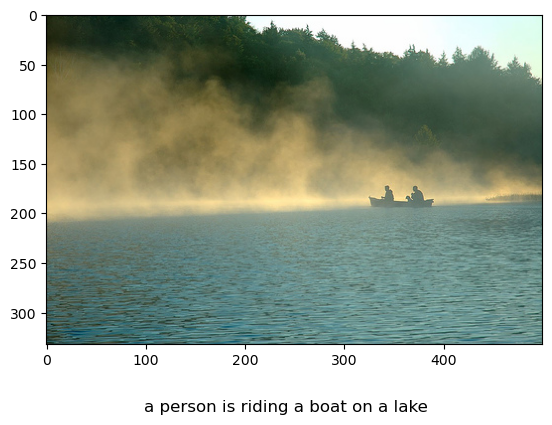

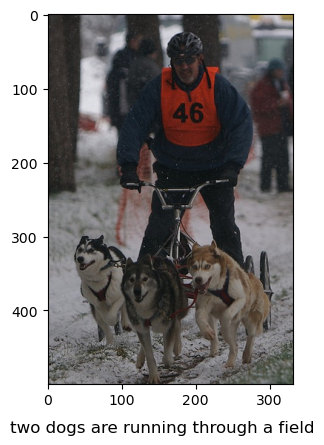

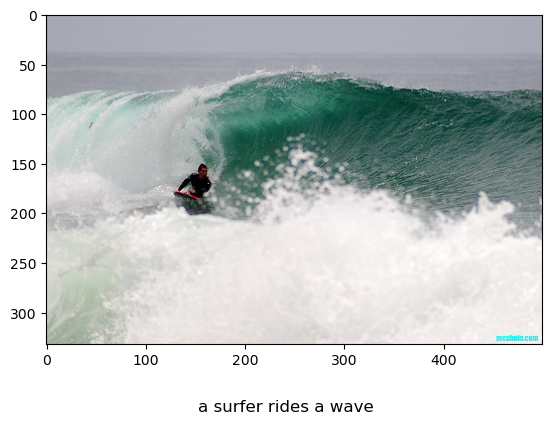

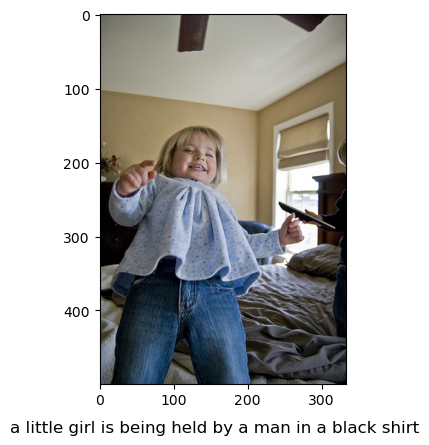

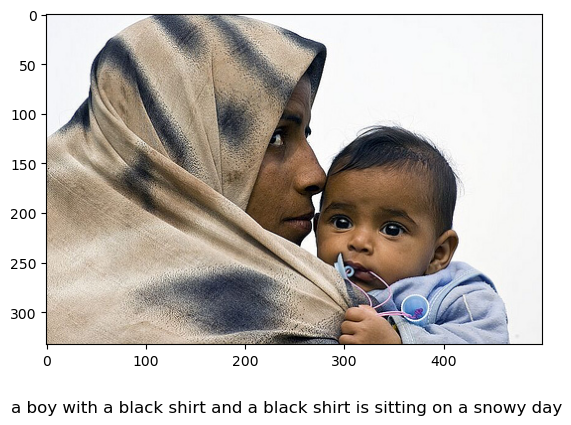

In [5]:
#preparing the dataset
train = load_dataset("Flickr8k_text/Flickr_8k.trainImages.txt")
dev = load_dataset("Flickr8k_text/Flickr_8k.devImages.txt")
test = load_dataset("Flickr8k_text/Flickr_8k.testImages.txt")

file_name = None
if feature_model.lower() == 'custom':
    file_name = 'cnn_features.pkl' 
if feature_model.lower() == 'resnet50':
    file_name = 'resnet_features.pkl'
else:
    file_name = 'vgg16_features.pkl'
    
train_caption_dict = load_captions(train, 1)
train_features = load_image_features(train,file_name)
dev_caption_dict = load_captions(dev, 1)
dev_features = load_image_features(dev, file_name)
test_caption_dict = load_captions(test, 0)
test_features = load_image_features(test, file_name)



#Preparing the Embeddings
path_to_glove_file = "archive-2/glove.6B.100d.txt"
embeddings_index = {}
with open(path_to_glove_file, 'r', encoding='utf-8') as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

#Initialize embedding matrix
embed_dim = 100
vocab_size = 3001
embedding_matrix = np.zeros((vocab_size, embed_dim))
tokenizer = create_tokenizer(train_caption_dict, num_vocab=vocab_size)
coverage = set()
for i in range(1, vocab_size):
    w = tokenizer.index_word[i]
    if w in embeddings_index.keys():
        embedding_matrix[i] = embeddings_index.get(w) #use the pre-trained embeddings, set 0 otherwise
        coverage.add(w)

max_length = max([len(c.split()) for c in captions_to_list(train_caption_dict)]) - 1 #Maximum length of input sequence

#Save the tokenizer for caption_generation
with open("tokenizer.json", "w") as f:
    json.dump(tokenizer.to_json(), f)


#Training:
num_epoches = 20
batch_size = 32 #photos per batch
num_photos = 32
steps_per_epoch = int(len(train_caption_dict) / num_photos)
val_steps = int(len(dev_caption_dict) / num_photos)


if sequence_model.lower() == 'lstm':
    model = define_model_lstm(max_length, vocab_size, dp_rate=0.1, embed_size=embed_dim, embedding_matrix=embedding_matrix)
    
else:
    model = define_model_rnn(max_length, vocab_size, dp_rate=0.1, embed_size=embed_dim, embedding_matrix=embedding_matrix)

    
train_generator = generate_dataset(train_caption_dict, train_features, tokenizer, max_length, vocab_size, batch_size)
dev_generator = generate_dataset(dev_caption_dict, dev_features, tokenizer, max_length, vocab_size, batch_size )

for i in range(num_epoches):
    hist = model.fit(train_generator, steps_per_epoch = steps_per_epoch, epochs=5, verbose=1)

    train_loss = hist.history['loss'][-1]
    dev_loss = model.evaluate_generator(dev_generator, steps = val_steps, verbose=1)
    print("The dev_loss at {i}-th epoch: {dev_loss}".format(i=i, dev_loss=np.round(dev_loss,2)))
model.save(f"{feature_model}_{sequence_model}_model.keras")
        
        
#Evaluating the model
evaluate_model(model, tokenizer, test_caption_dict, test_features, max_length, vocab_size)

#Fine-tuning on embedding layers

model.get_layer('text_embedding').trainable = True
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
for i in range(5):
    hist = model.fit(train_generator, steps_per_epoch = steps_per_epoch, epochs=5, verbose=1)

    train_loss = hist.history['loss'][-1]
    dev_loss = model.evaluate(dev_generator, steps = val_steps, verbose=1)
    print("The dev_loss at {i}-th epoch: {dev_loss}".format(i=i, dev_loss=np.round(dev_loss,2)))

model.save(f"enhanced_{feature_model}_{sequence_model}_model.keras")